In [59]:
import numpy as np
import torch
from torch.autograd import Variable
import os
import sys
import matplotlib.pyplot as plt

In [118]:
path_to_pydeformetrica = '/Users/maxime.louis/Documents/pydeformetrica'
sys.path.append(os.path.join(path_to_pydeformetrica, '../'))
from pydeformetrica.src.in_out.xml_parameters import XmlParameters
from pydeformetrica.src.in_out.dataset_functions import create_template_metadata
from pydeformetrica.src.in_out.deformable_object_reader import DeformableObjectReader
from pydeformetrica.src.core.model_tools.attachments.multi_object_attachment import MultiObjectAttachment
from pydeformetrica.src.support.kernels.kernel_functions import create_kernel
from pydeformetrica.src.support.utilities.general_settings import Settings
from src.in_out.array_readers_and_writers import *

In [119]:
path_experiments = '/Users/maxime.louis/Documents/metric_learning/synthetic_image'

experiment_number = 1
###suffix = '_no_averaging_'
suffix = '_'

path_synthetic = os.path.join(path_experiments, 'synthetic_dataset' + suffix + str(experiment_number))

path_to_output = os.path.join(path_synthetic, 'output')
path_to_test_registration = os.path.join(path_synthetic, 'registration_test')
path_to_train_registration = os.path.join(path_synthetic, 'registration_train')
optimization_parameters_xml_path = os.path.join(path_experiments, 'optimization_parameters.xml')
train_model_name = 'LongitudinalMetricModel'
test_model_name = 'LongitudinalRegistration'
initialized_model_xml_path = os.path.join(path_synthetic, 'model_after_initialization.xml')


dataset_xml_path = os.path.join(path_synthetic, 'data_set_train_starfish_' + str(experiment_number) + '.xml')
#dataset_xml_path = os.path.join(path_to_atlas, 'data_set.xml')





xml_parameters = XmlParameters()
xml_parameters.read_all_xmls(initialized_model_xml_path, dataset_xml_path, optimization_parameters_xml_path)

>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p


In [120]:
path_to_trajectory = os.path.join(path_to_output, train_model_name + '__EstimatedParameters__Trajectory.npy')
trajectory_all_parameters = np.load(path_to_trajectory)[()]
for key, val in trajectory_all_parameters.items():
    print(key, val.shape)

p0 (201, 3)
reference_time (201, 1)
v0 (201, 3)
onset_age_variance (201, 1)
log_acceleration_variance (201, 1)
noise_variance (201, 1)
modulation_matrix (201, 6)
metric_parameters (201, 4313)


# 1. Print parameters trajectory


Number of nn parameters: 4313


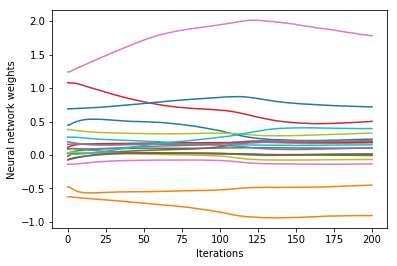

In [121]:
# neural network parameters
nn_parameters = trajectory_all_parameters['metric_parameters']
print('Number of nn parameters:', len(nn_parameters[0]))
for i in range(20):
    plt.plot(nn_parameters[:, i])
plt.ylabel("Neural network weights")
plt.xlabel("Iterations")
plt.show()
    

Final noise variance: 0.00257161182114


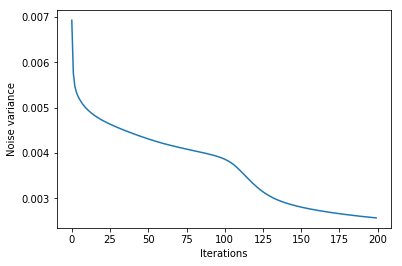

In [122]:
# noise variance 
noise_variances = trajectory_all_parameters['noise_variance'][1:]
#print(noise_variances)
print("Final noise variance:", noise_variances[-1][0])
plt.plot(noise_variances)
plt.ylabel("Noise variance")
plt.xlabel("Iterations")
plt.legend()
plt.show()

# 3 Absolute times

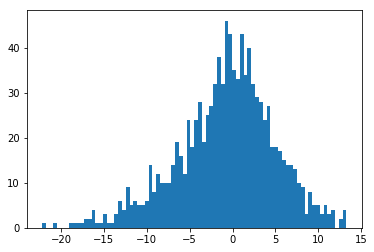

In [123]:
# Absolute times Plotting the histogram for the last observation
abs_times = np.loadtxt(os.path.join(path_to_output, train_model_name + "_absolute_times.txt"))
plt.hist(abs_times, bins=80)
plt.show()

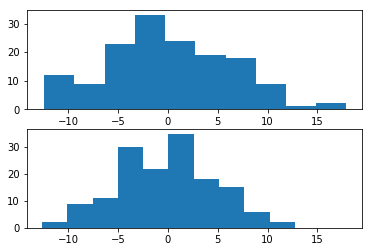

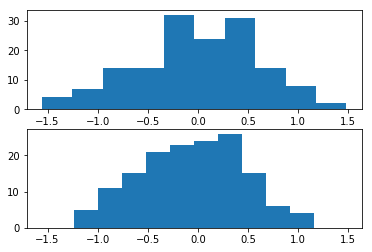

In [126]:
# Last realisations for the alphas and onset ages
log_accelerations = np.loadtxt(os.path.join(path_to_output, train_model_name + "_log_accelerations.txt"))
onset_ages = np.loadtxt(os.path.join(path_to_output, train_model_name + "_onset_ages.txt"))
info = np.loadtxt('/Users/maxime.louis/Documents/metric_learning/synthetic_image/info_subjects'+suffix+'synthetic_dataset'+
                  suffix + str(experiment_number) + '.txt') [:150, :]
log_accelerations_truth = np.log(info[:,0])
onset_ages_truth = info[:,1]

ax1 = plt.subplot(211)
plt.hist(onset_ages, bins=10)
plt.xlabel(' onset ages distribution')
ax2 = plt.subplot(212, sharex=ax1)
plt.hist(onset_ages_truth, bins=10)
plt.show()

ax1 = plt.subplot(211)
plt.hist(log_accelerations, bins=10)
ax2 = plt.subplot(212, sharex=ax1)
plt.hist(log_accelerations_truth, bins=10)
plt.show()



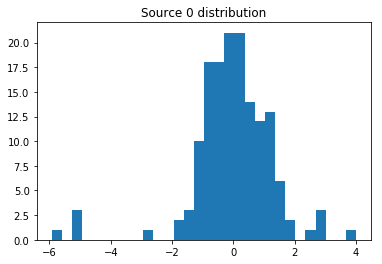

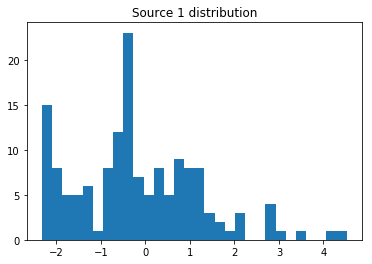

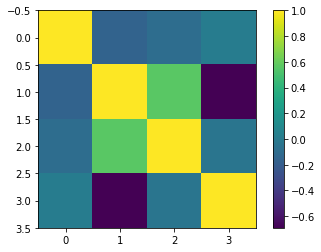

In [127]:
sources = np.loadtxt(os.path.join(path_to_output, train_model_name + "_sources.txt"))
if len(sources.shape) == 1:
    sources = sources.reshape(len(sources), 1)
number_of_sources = len(sources[0])
for i in range(len(sources[0])):
    plt.hist(sources[:, i], bins=30)
    plt.title("Source "+str(i)+" distribution")
    plt.show()
    
real_info = info[:,4:-1]
corr_matrix = np.corrcoef(sources.T, real_info.T)
plt.imshow(corr_matrix)
plt.colorbar()
plt.show()

Log acceleration avg error on train: 0.290612576358
Onset ages avg error on train: 2.76605884627


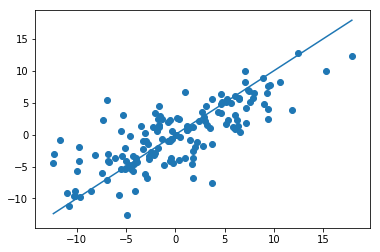

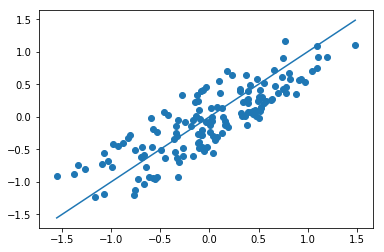

(150, 2)


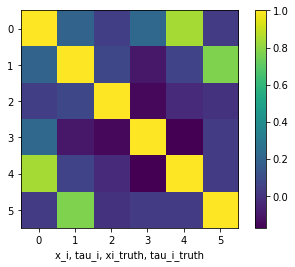

In [136]:
log_acceleration_error = np.mean(np.abs(log_accelerations-log_accelerations_truth))
print("Log acceleration avg error on train:", log_acceleration_error)

onset_ages_error = np.mean(np.abs(onset_ages-onset_ages_truth))
print("Onset ages avg error on train:", onset_ages_error)

plt.plot([np.min(onset_ages),np.max(onset_ages)],[np.min(onset_ages),np.max(onset_ages)])
plt.scatter(onset_ages, onset_ages_truth)
plt.show()

plt.plot([np.min(log_accelerations), np.max(log_accelerations)],[np.min(log_accelerations), np.max(log_accelerations)])
plt.scatter(log_accelerations, log_accelerations_truth)
plt.show()
print(sources.shape)
corr_matrix = np.corrcoef([log_accelerations, onset_ages, sources[:,0], sources[:,1], log_accelerations_truth, onset_ages_truth])
plt.imshow(corr_matrix)
plt.xlabel('x_i, tau_i, xi_truth, tau_i_truth')
plt.colorbar()
plt.show()

Log acceleration avg error on test: 0.274297959035
Onset ages avg error on test: 3.02672136585


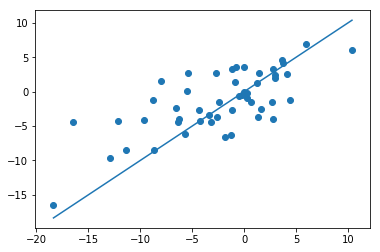

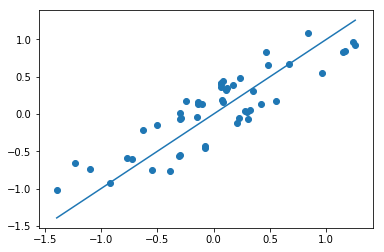

Train residuals: 0.125384453333 Test residuals 0.12578656
Train residuals registration 0.12409034
Train residuals: 0.125384453333 Test residuals 0.12578656


In [137]:
# We also want test set onset ages an alphas as well as residuals.
test_onset_ages = np.loadtxt(os.path.join(path_to_test_registration, 'LongitudinalRegistration_onset_ages.txt'))
test_log_accelerations = np.loadtxt(os.path.join(path_to_test_registration, 'LongitudinalRegistration_log_accelerations.txt'))
info_test = np.loadtxt('/Users/maxime.louis/Documents/metric_learning/synthetic_image/info_subjects'+suffix+'synthetic_dataset_'+
                  str(experiment_number) + '.txt')[150:, :]
test_log_accelerations_truth = np.log(info_test[:, 0])
test_onset_ages_truth = info_test[:,1]
                                    
test_log_acceleration_error = np.mean(np.abs(test_log_accelerations-test_log_accelerations_truth))
print("Log acceleration avg error on test:", test_log_acceleration_error)

test_onset_ages_error = np.mean(np.abs(test_onset_ages-test_onset_ages_truth))
print("Onset ages avg error on test:", test_onset_ages_error)

plt.plot([np.min(test_onset_ages),np.max(test_onset_ages)],[np.min(test_onset_ages),np.max(test_onset_ages)])
plt.scatter(test_onset_ages, test_onset_ages_truth)
plt.show()

plt.plot([np.min(test_log_accelerations), np.max(test_log_accelerations)],[np.min(test_log_accelerations), np.max(test_log_accelerations)])
plt.scatter(test_log_accelerations, test_log_accelerations_truth)
plt.show()

# Noise level
train_residuals = np.loadtxt(os.path.join(path_to_output, train_model_name + '_residuals.txt'))
train_residuals_registration = np.loadtxt(os.path.join(path_to_train_registration, test_model_name + '_residuals.txt'))
test_residuals = np.loadtxt(os.path.join(path_to_test_registration, test_model_name + '_residuals.txt'))
print('Train residuals:', np.mean(train_residuals), 'Test residuals', np.mean(test_residuals))
print('Train residuals registration', np.mean(train_residuals_registration))

noise = np.load(os.path.join(path_experiments,'noise'+ suffix + str(experiment_number)+'.npy'))

train_residuals_registation = np.loadtxt(os.path.join(path_to_train_registration, test_model_name + '_residuals.txt'))
test_residuals = np.loadtxt(os.path.join(path_to_test_registration, test_model_name + '_residuals.txt'))
print('Train residuals:', np.mean(train_residuals), 'Test residuals', np.mean(test_residuals))

# 3 Plotting some images


In [131]:
from PIL import Image
def load_images(l):
    return [np.load(elt) for elt in l]

def load_image_trajectory(folder):
    #image_paths = [elt for elt in os.listdir(folder) if elt.find('.png') >= 0]
    image_paths = [elt for elt in os.listdir(folder) if elt.find('.npy') >= 0]
    image_paths = sorted(image_paths, key=(lambda x: float(x[x.find('_t__')+4 : x.find('.npy')])))
    to_keep = 7
    image_paths_aux = []
    if len(image_paths) > to_keep:
        stride = int(len(image_paths)/to_keep)
        for i in range(to_keep):
            image_paths_aux.append(image_paths[i*stride])
        image_paths = image_paths_aux
    print(image_paths)
    return load_images([os.path.join(folder, elt) for elt in image_paths])
    #return [np.array(Image.open(os.path.join(folder, elt)))/255 for elt in image_paths]
    
def plot_images(images):   
    plt.clf()
    f, axes = plt.subplots(1, len(images), figsize=(20, 10))
    max_intensity = np.max(np.array(images))
    min_intensity = np.min(np.array(images))
    for i,ax in enumerate(axes):
        im = ax.imshow(images[i], cmap='inferno', vmin=min_intensity, vmax=max_intensity)
        ax.set_title(str(np.min(images[i]))[:3] + " " + str(np.max(images[i]))[:3] + "_" + str(np.sum(images[i]**2))[:4])
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.4, 0.01, 0.2])
    f.colorbar(im, cax=cbar_ax)
    plt.show()
        


['LongitudinalMetricModel_geodesic_t__0.npy', 'LongitudinalMetricModel_geodesic_t__25.npy', 'LongitudinalMetricModel_geodesic_t__50.npy', 'LongitudinalMetricModel_geodesic_t__75.npy', 'LongitudinalMetricModel_geodesic_t__100.npy', 'LongitudinalMetricModel_geodesic_t__125.npy', 'LongitudinalMetricModel_geodesic_t__150.npy']


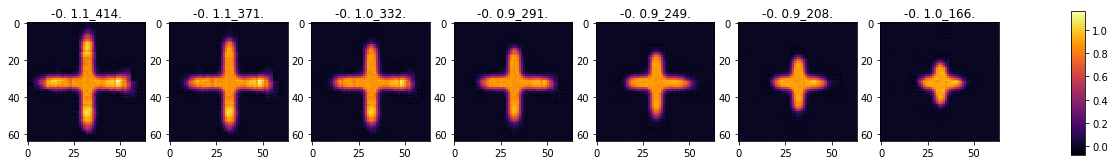

In [132]:
# Geodesic trajectory
geodesic_folder = os.path.join(path_to_output, 'geodesic_trajectory')
geodesic_images = load_image_trajectory(geodesic_folder)
plot_images(geodesic_images)

['LongitudinalMetricModel_parallel_curve_neg_0_t__0.npy', 'LongitudinalMetricModel_parallel_curve_neg_0_t__2.npy', 'LongitudinalMetricModel_parallel_curve_neg_0_t__4.npy', 'LongitudinalMetricModel_parallel_curve_neg_0_t__6.npy', 'LongitudinalMetricModel_parallel_curve_neg_0_t__8.npy', 'LongitudinalMetricModel_parallel_curve_neg_0_t__10.npy', 'LongitudinalMetricModel_parallel_curve_neg_0_t__12.npy']
['LongitudinalMetricModel_parallel_curve_neg_1_t__0.npy', 'LongitudinalMetricModel_parallel_curve_neg_1_t__2.npy', 'LongitudinalMetricModel_parallel_curve_neg_1_t__4.npy', 'LongitudinalMetricModel_parallel_curve_neg_1_t__6.npy', 'LongitudinalMetricModel_parallel_curve_neg_1_t__8.npy', 'LongitudinalMetricModel_parallel_curve_neg_1_t__10.npy', 'LongitudinalMetricModel_parallel_curve_neg_1_t__12.npy']
2


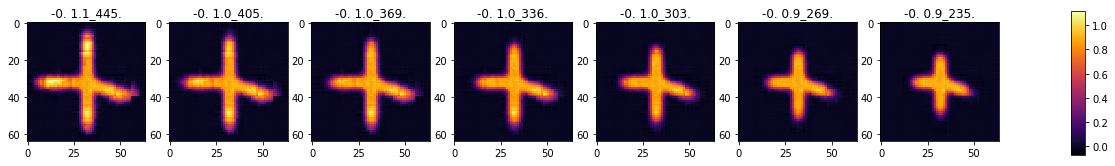

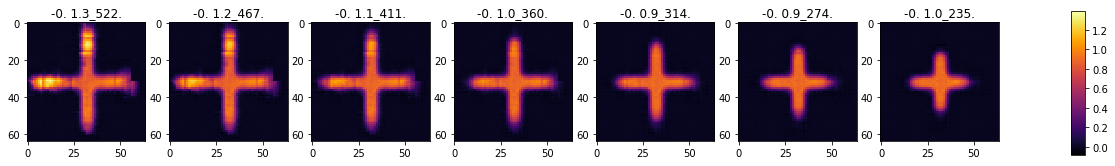

In [133]:
# First source
sources_traj = []
for i in range(number_of_sources):
    source_folder = os.path.join(path_to_output, 'parallel_curve_neg_' + str(i))
    sources_traj.append(load_image_trajectory(source_folder))
print(len(sources_traj))
for i in range(number_of_sources):
    plot_images(sources_traj[i])

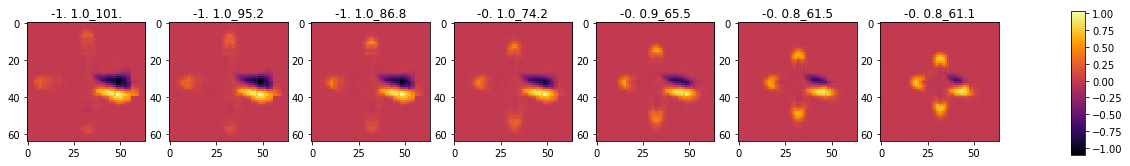

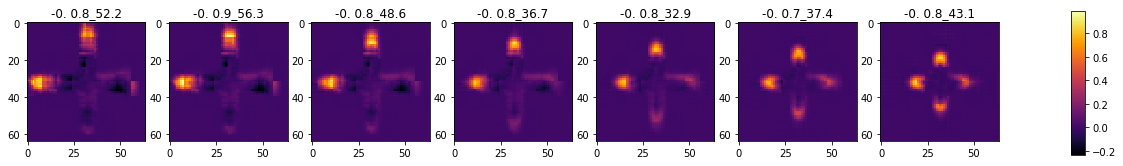

In [134]:
diff_sources_traj =[]
for i in range(number_of_sources):
    diff_sources_traj.append([sources_traj[i][j] - geodesic_images[j] for j in range(len(geodesic_images))])
for elt in diff_sources_traj:
    plot_images(elt)


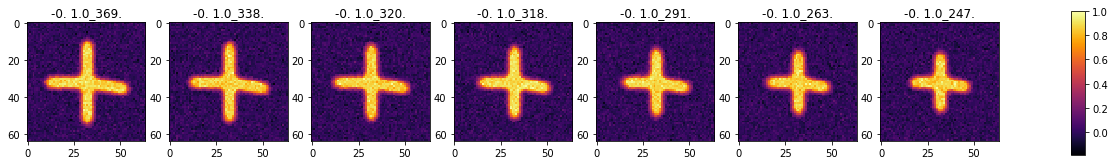

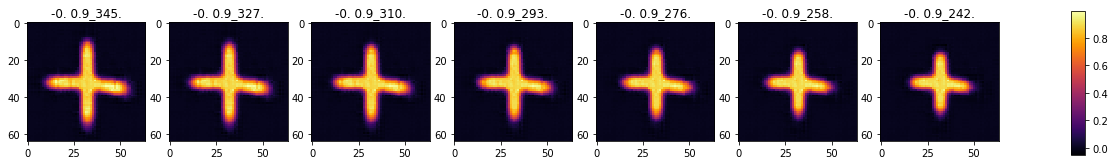

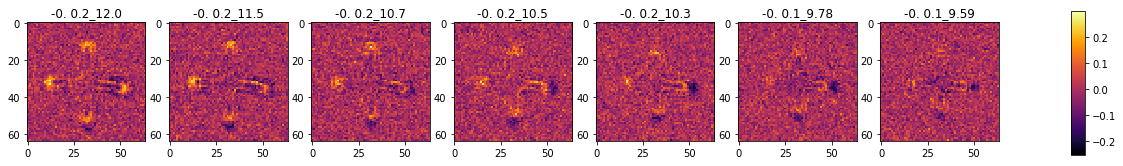

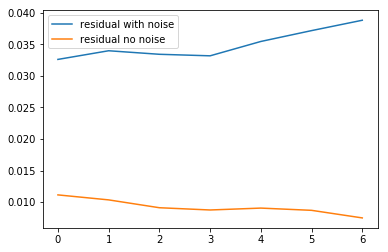

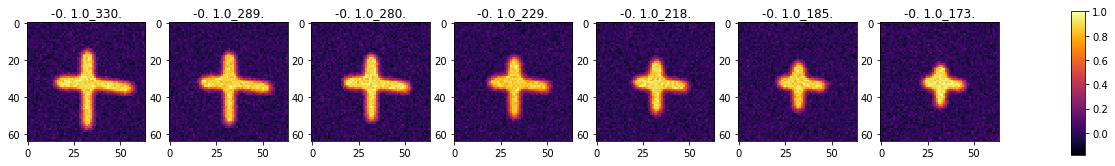

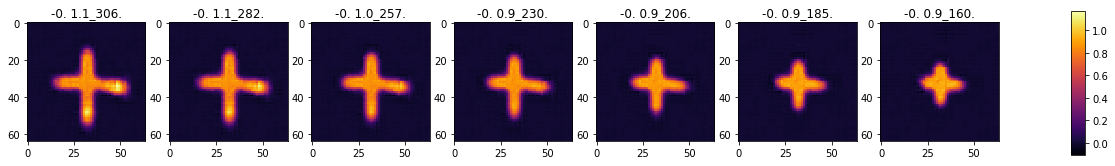

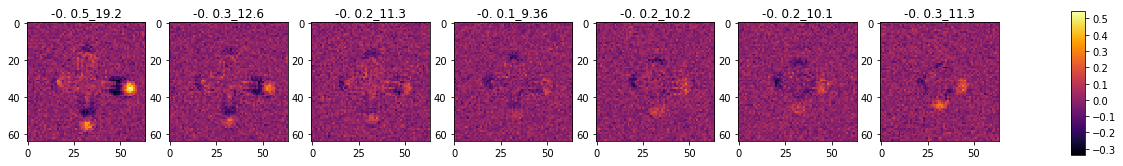

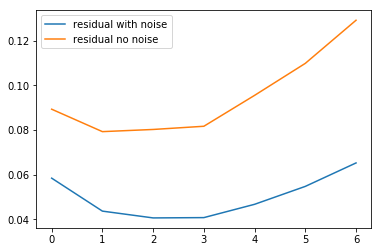

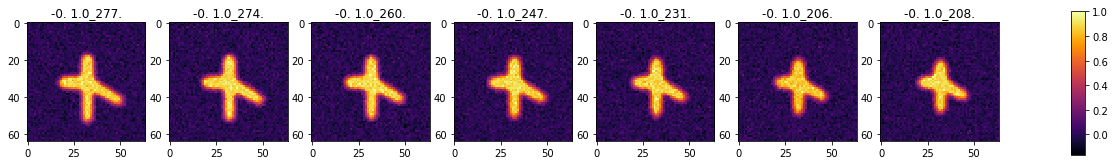

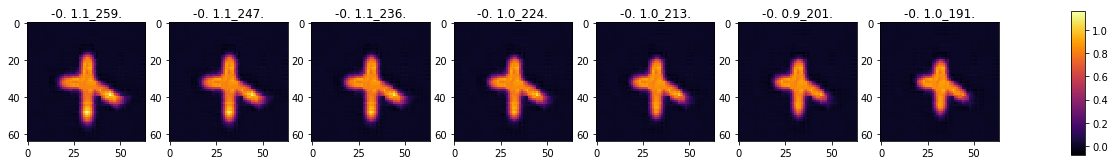

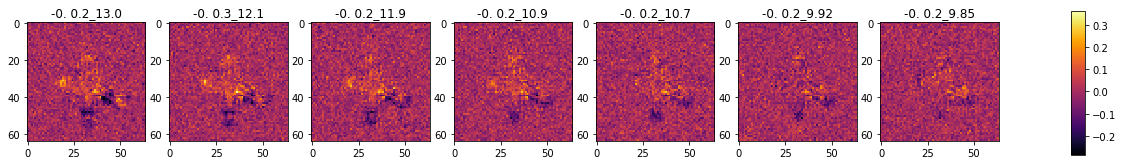

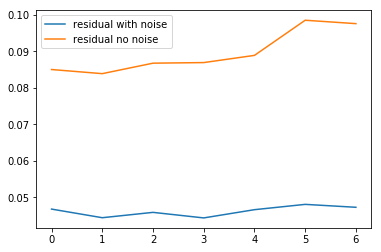

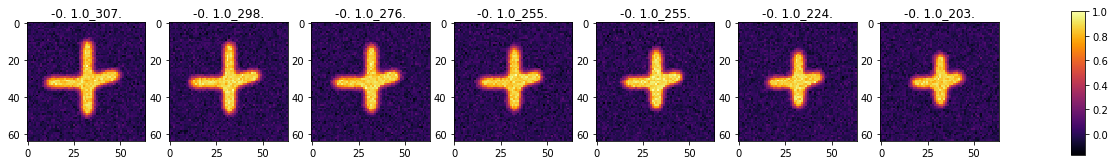

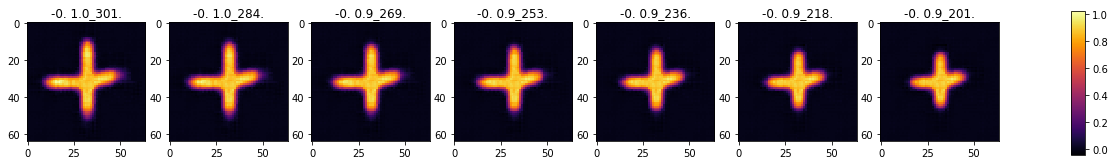

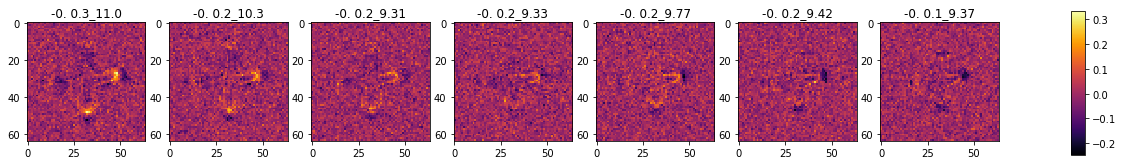

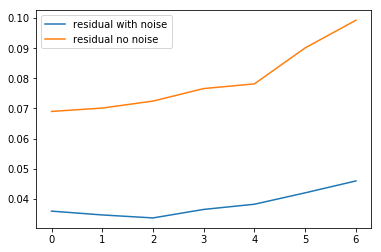

In [135]:
def load_subject_images(i):
    data_dir = '/Users/maxime.louis/Documents/metric_learning/synthetic_image/synthetic_dataset_' + str(experiment_number)
    subject_targets = [elt for elt in os.listdir(data_dir) if elt.find('al_'+str(i)+'_t_')>0]
    sorted_targets = sorted(subject_targets, key=(lambda x: float(x[x.find('_t_')+3 : x.find('.npy')])))
    #print([os.path.join(data_dir, elt) for elt in sorted_targets])
    return load_images([os.path.join(data_dir, elt) for elt in sorted_targets])
    
def load_reconstructed_images(i):
    subject_folder = os.path.join(path_to_output, 'subject_'+str(i))
    paths = [elt for elt in os.listdir(subject_folder) if elt.find('.npy')>0]
    sorted_paths = sorted(paths, key=(lambda x: float(x[x.find('_t__')+4 : x.find('.npy')])))
    #print([os.path.join(subject_folder, elt) for elt in sorted_paths])
    return load_images([os.path.join(subject_folder, elt) for elt in sorted_paths])
        
for i in range(4):
    targets = np.array(load_subject_images(i))
    reconstructed = load_reconstructed_images(i)
    residuals = np.array([targets[k] - reconstructed[k] for k in range(len(targets))])
    residuals_to_unnoised = np.array([targets[k] - noise[k] - reconstructed[k] for k in range(len(targets))])
    plot_images(targets)
    plot_images(reconstructed)
    plot_images(residuals)
    plt.plot(np.sum(np.sum(residuals**2, axis=2), axis=1)/np.sum(np.sum(targets**2, axis=2), axis=1), label='residual with noise')
    plt.plot(np.sum(np.sum(residuals_to_unnoised**2, axis=2), axis=1)/np.sum(np.sum(targets**2, axis=2), axis=1), label='residual no noise')
    plt.legend()
    plt.show()
    